In [21]:
import os
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, pinv
%matplotlib inline
np.set_printoptions(precision=12, suppress=True)

In [2]:
zoomed_coords = True # whether to divide coordinates by SCALE_FAC or not (zoomed coords or not)
center_only = True # use only central stars
SCALE_FAC = 4.0 # Scale factor of coordinates

In [3]:
coords_folder = 'data/star_coords/2016nov-11_txt/' # folder with coords files
images_folder = 'data/stars/2016nov-11/'
results_folder = 'results/2016nov-11/'

In [7]:
# 2016nov-11 jpg
fnames = [
    "20161122-191517-359.txt",
    "20161122-201517-375.txt",
    "20161122-211517-375.txt",
    "20161122-221517-375.txt"
]

In [9]:
date = fnames[0][:-4]

In [10]:
im = Image.open(images_folder + "mod_" + date + "-1.jpg")
w, h = im.size
print "Image size:", w, h

Image size: 3072 2304


In [11]:
CENTER_RAD = h/4 # radius(px) of central part
x_c, y_c = w/2, h/2 # central point of img
print 'x_c, y_c:', x_c, y_c
print 'CENTER_RAD:', CENTER_RAD

x_c, y_c: 1536 1152
CENTER_RAD: 576


"1." Берем область (круг) с центром в середине кадра, разных радиусов.
Считаем количество звезд. Определяем координаты выделенных звезд,
стараясь брать звезды малого размера, занимающих один пиксель.
Число звезд в кругах должно  отличаться на 3-4.

* R1 = 576px; 11 звезд учитыв-ся при подсчете коэфф
* R2 = 476px; 8 звезд учитыв-ся при подсчете коэфф

In [18]:
coords_list = []
for fname in fnames:
    piece = np.loadtxt(coords_folder + os.sep + fname)
    coords_list.append(piece)

coords = np.vstack(coords_list)
print 'Zoomed In Star coordinates pairs (first 5):\n', coords[:5], '\n'

if zoomed_coords:
    coords /= float(SCALE_FAC)
    coords = coords.round()
    print 'Normal Star coordinates pairs (first 5):\n', coords[:5], '\n'


if center_only:
    coords_center = []
    
    for i in xrange(coords.shape[0]):
        _lx = coords[i, 0]
        _ly = coords[i, 1]
        _rx = coords[i, 2]
        _ry = coords[i, 3]
        if \
        (_lx - x_c)**2 + (_ly - y_c)**2 <= CENTER_RAD**2 and \
        (_rx - x_c)**2 + (_ry - y_c)**2 <= CENTER_RAD**2:
            coords_center.append(coords[i])
    
    coords = np.vstack(coords_center)
    print 'Normal Star coordinates pairs in center:\n', coords, '\n'
    print 'Num of star pairs chosen:', len(coords)

Zoomed In Star coordinates pairs (first 5):
[[  5734.   6266.   6711.   6411.]
 [  6490.   6723.   7468.   6866.]
 [  5934.   7360.   6910.   7507.]
 [  6209.   7975.   7190.   8129.]
 [  9774.   8478.  10880.   8711.]] 

Normal Star coordinates pairs (first 5):
[[ 1434.  1566.  1678.  1603.]
 [ 1622.  1681.  1867.  1716.]
 [ 1484.  1840.  1728.  1877.]
 [ 1552.  1994.  1798.  2032.]
 [ 2444.  2120.  2720.  2178.]] 

Normal Star coordinates pairs in center:
[[ 1434.  1566.  1678.  1603.]
 [ 1231.  1291.  1474.  1328.]
 [ 1438.  1360.  1680.  1397.]
 [ 1338.  1543.  1582.  1579.]
 [ 1436.  1673.  1680.  1709.]
 [  972.  1066.  1216.  1107.]
 [ 1192.  1089.  1433.  1128.]
 [ 1132.  1289.  1376.  1327.]
 [ 1256.  1393.  1499.  1430.]
 [ 1637.  1413.  1880.  1448.]
 [ 1019.  1160.  1264.  1200.]] 

Num of star pairs chosen: 11


In [24]:
lX = coords[:, 0] # leftX coordinates
lY = coords[:, 1] # leftY coordinates
rX = coords[:, 2] # rightX coordinates
rY = coords[:, 3] # rightY coordinates

N = coords.shape[0] # number of pairs of points
M = coords.shape[1] # lX, lY, rX, rY == 4
print 'Number of Star coordinates pairs:', N

Number of Star coordinates pairs: 11


In [25]:
# Plot chosen star pairs
scatter_original = Image.new('RGB', (w, h), 'lightgray')
s_pix = scatter_original.load()

ELL_RAD = 3

scx_c = scatter_original.width / 2
scy_c = scatter_original.height / 2
draw = ImageDraw.Draw(scatter_original)
draw.ellipse((scx_c-ELL_RAD, scy_c-ELL_RAD, scx_c+ELL_RAD, scy_c+ELL_RAD), fill='darkgreen')

In [28]:
for i in xrange(N): # draw star points
    draw.ellipse((lX[i]-ELL_RAD, lY[i]-ELL_RAD, lX[i]+ELL_RAD, lY[i]+ELL_RAD), fill='red')
    draw.ellipse((rX[i]-ELL_RAD, rY[i]-ELL_RAD, rX[i]+ELL_RAD, rY[i]+ELL_RAD), fill='blue')

# Draw central part boundary
draw.ellipse((scx_c-CENTER_RAD, scy_c-CENTER_RAD, scx_c+CENTER_RAD, scy_c+CENTER_RAD), outline='black')

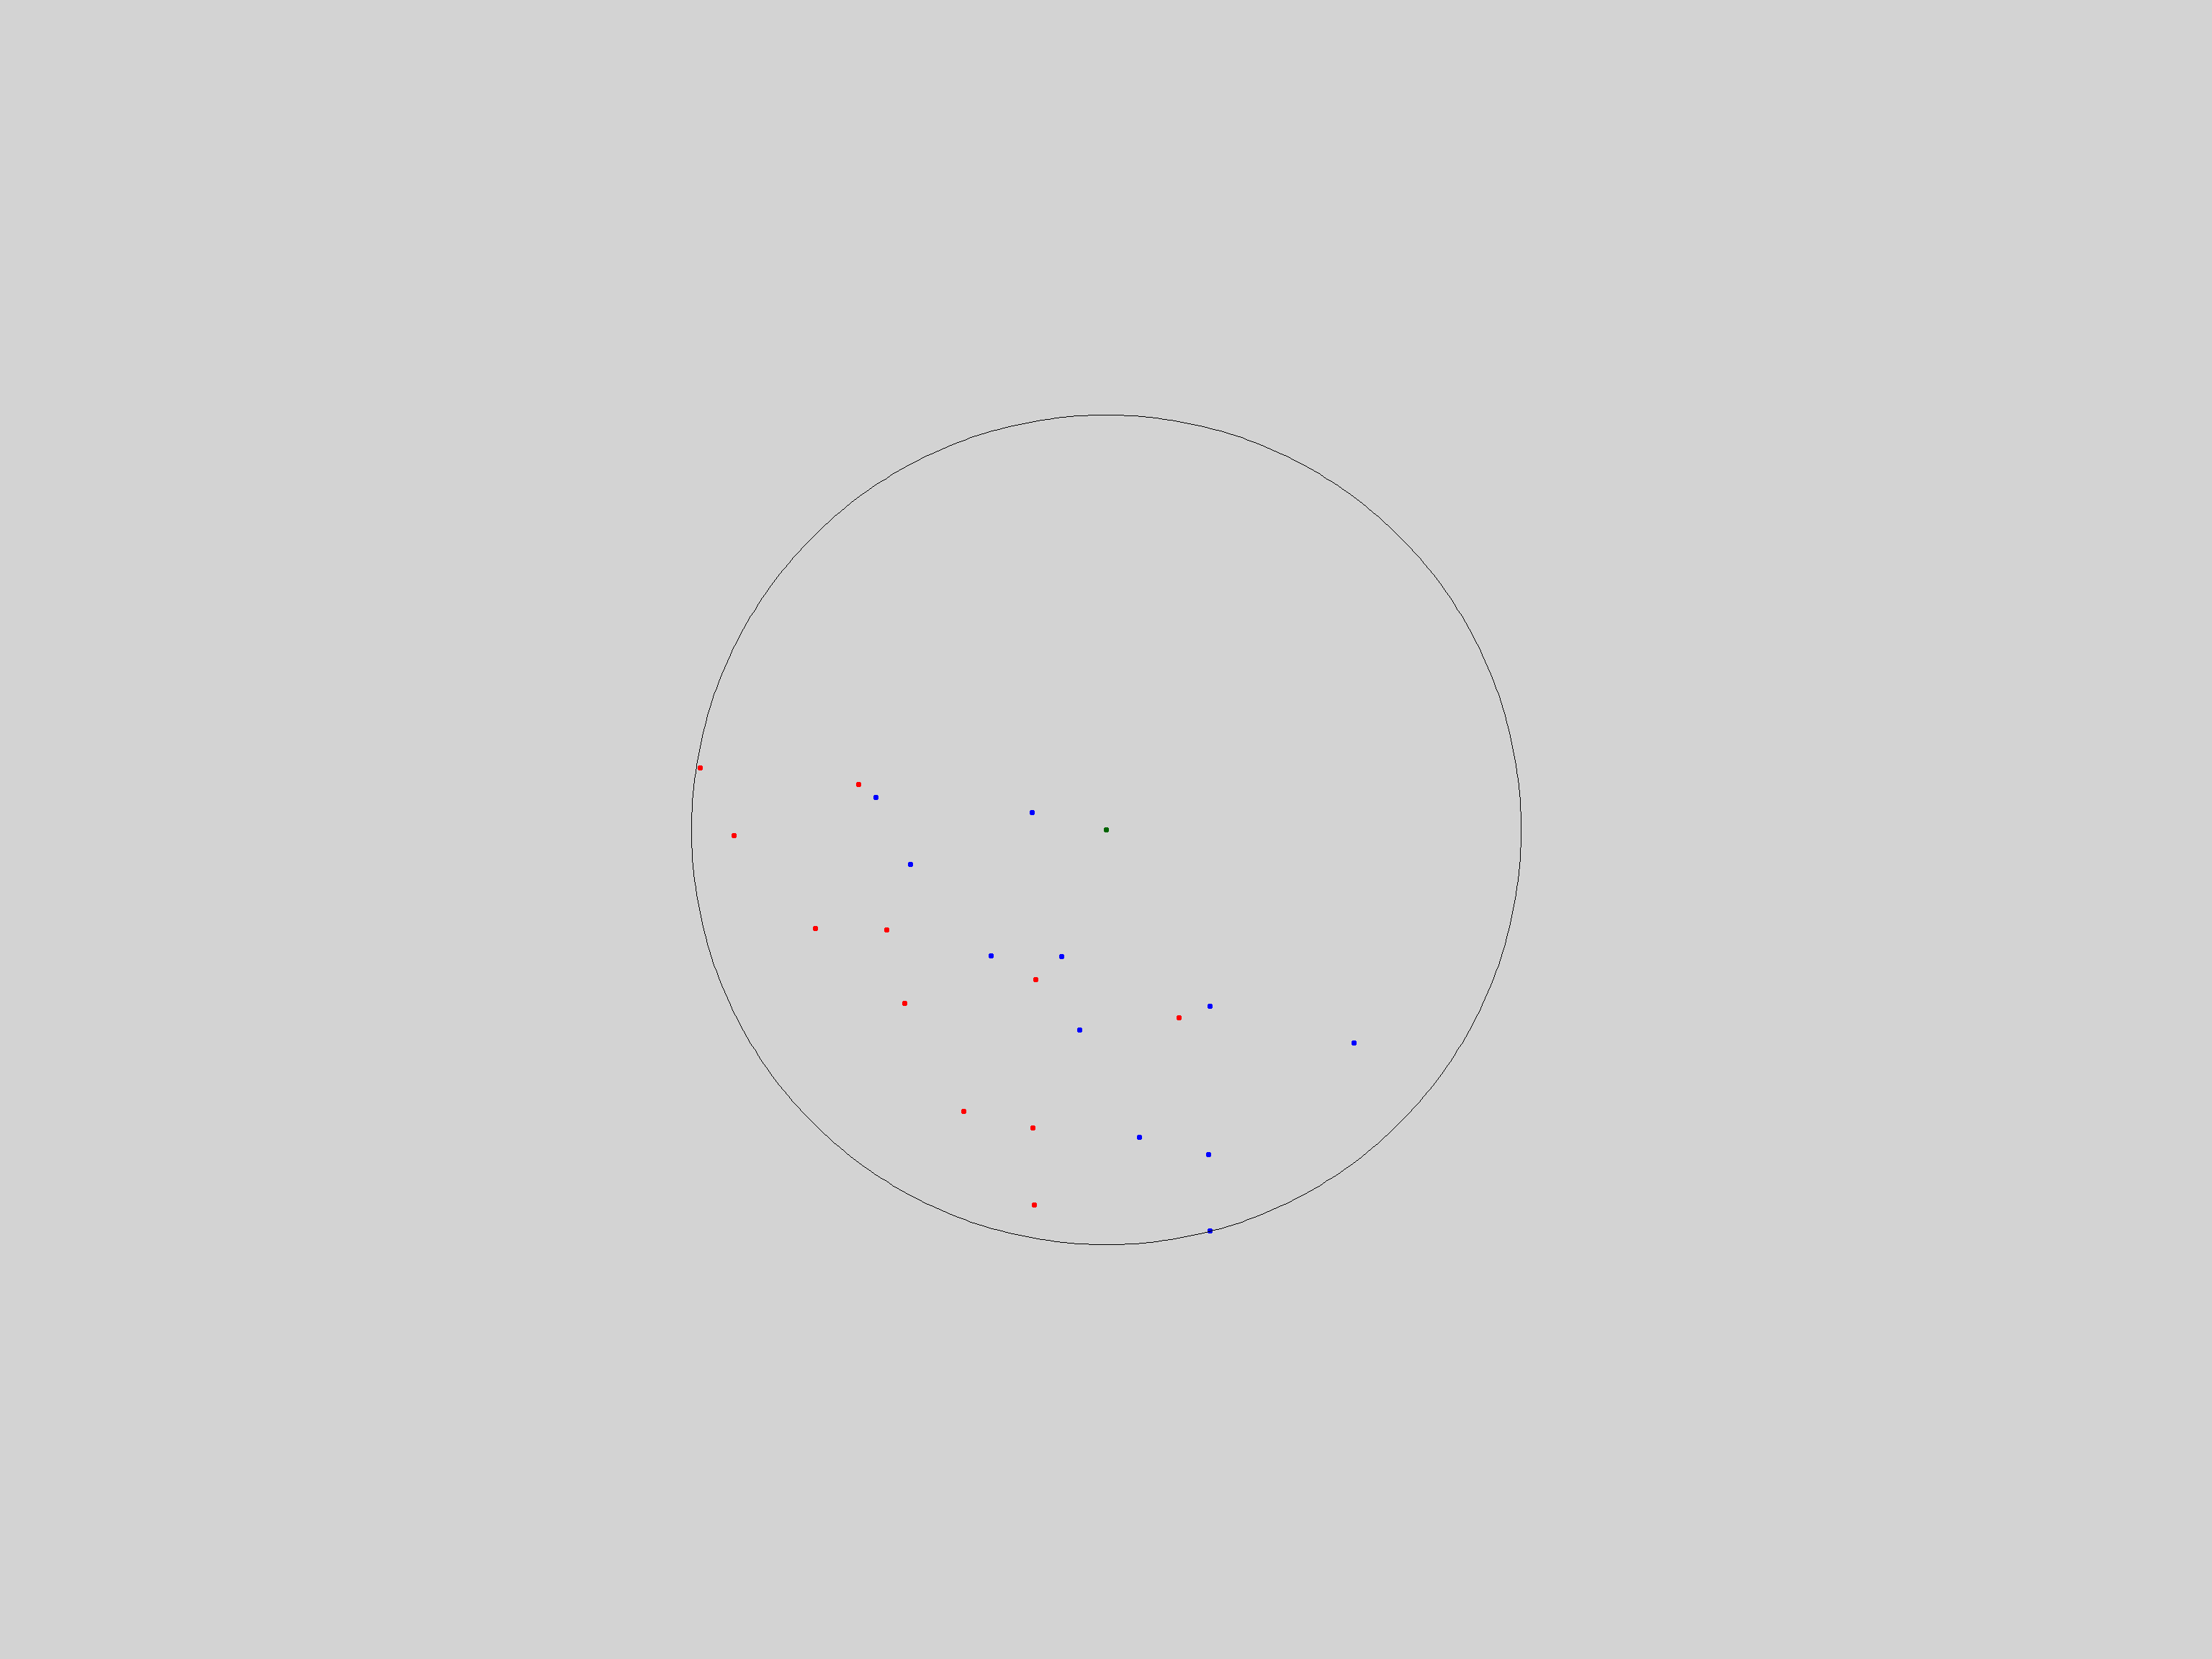

In [30]:
# Original stars' position
scatter_original

"2." Для каждого из набора звезд в выделенных кругах вычисляем
коэффициенты аффинного преобразования, коэффициенты
преобразования аффинного+дисторсии 3 порядка и коэффициенты
преобразования аффинного+дисторсии 3 порядка+дисторсии 5
порядка. Формулу для дисторсии 5 порядка можно посмотреть,
например, на сайте
https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D1%82%D0%BE%D1%80%D1%81%D0%B8%D1%8F

Для дисторсии высших порядков  ($F_{n} при \; n>3$) в формулу добавляют по одному слагаемому на каждую дисторсию нечётного порядка ($F_{3}, F_{5}, F_{7} \;$ и т.п.):

$
\vec{R} = b_{0}\vec {r} + F_{3} r^{2} \vec{r} + F_{5} r^{4} \vec{r} + F_{7} r^{6} \vec{r} + \dots
$

и написать по аналогии с третьим порядком. Число звезд должно быть
больше, чем половина числа неизвестных параметров.

Вычисление проводится так.
Запишем схему измерения
$$
\xi = Af + \nu ,
$$

задаем матрицу А, матрицу $\Sigma$, являющуюся диагональной, и на ее
диагонали стоят дисперсии координат вектора погрешности $\nu$ . Здесь $f$ -- вектор неизвестных коэффициентов преобразований. Считаем эти дисперсии равными единице, т.е. $\Sigma = I$ -- единичная матрица

Оценка коэффициентов вычисляется по формуле
$$
    \hat{f} = A^- \xi
$$

Погрешность оценки коэффициентов определяется матрицей
$$
    \Sigma_f = \left( A \Sigma A^* \right)^{-1} 
             = \left(A A^* \right)^{-1}
$$

Надежность модели определяется значением случайной величины
$$
    \tau = \| \xi - AA^{-} \xi \|^2
$$

Выходные данные программы:

1) N – число звезд в круге

2) оценка коэффициентов $\; \hat{f} = A^- \xi$

3) матрица ошибок $\; \Sigma_f$

4) значение $\; \tau$ , а лучше – значение $\; \frac{2N - k}{\tau}$,
где k -- число коэффициентов (координат вектора f).

"3." Вычисляем преобразованное изображение одного из кадров и
накладываем его на изображение второго кадра. Для каждой звезды
вычисляем разность координат (по x и по y) двух (совмещенных) изображений звезд.

Выходные данные программы:

1) $\Delta x_i, \Delta y_i, \; i = 1,N$

2) $\sigma^2 = \frac{1}{N} \sum\limits_{i=1}^{N} 
                \left( \Delta x_i^2 + \Delta y_i^2 \right)$
                
3) $ 
     M_x = \max\limits_{i=1,N} \{\Delta x_i\}, \;
     M_y = \max\limits_{i=1,N} \{\Delta y_i\}, \;
     M = \max\{M_x, M_y\}
   $                

"4." Построить графики зависимости $\sigma$ и $M$ от размера круга для аффинного, аффин+дист.3 порядка и аффин+дист.3 порядка+дист 5
порядка.